## tsne 表征学习
- t-SNE
- 聚类结果可视化
- sklearn.manifold.TSNE

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn import datasets
from sklearn.manifold import TSNE
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # transforms.Grayscale(3),
    # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # 归一化到(0,1) 分布到(-1,1)
])
dataset1 = torchvision.datasets.MNIST(root="../../data", train=True, download=True, transform=transform)
dataset2 = torchvision.datasets.MNIST(root="../../data", train=False, download=False, transform=transform)

train_loader: DataLoader = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=True)
test_loader: DataLoader = torch.utils.data.DataLoader(dataset2, batch_size=1000, shuffle=True)

In [3]:
def train(model: nn.Module, device, train_loader, optimizer: torch.optim.Optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()

        optimizer.step()

        if batch_idx % 100 == 0:
            # Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.142410
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))


def test(model: nn.Module, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdims=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # Test set: Average loss: 0.0483, Accuracy: 9849/10000 (98%)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss,
        correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [4]:
class MyModel(nn.Module):  # e1 99%
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        self.dropout1 = nn.Dropout(.25)
        self.dropout2 = nn.Dropout(.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):  # batch_size=64, 1, 28, 28
        x = self.conv1(x)  # 32, 26, 26
        x = F.relu(x)
        x = self.conv2(x)  # 64, 24, 24
        x = F.relu(x)

        x = F.max_pool2d(x, 2)  # 64, 12, 12
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # 9216
        x = self.fc1(x)  # 64, 128
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)  # 10

        x = F.log_softmax(x, dim=1)  # 10
        return x

In [5]:
model = MyModel().cuda()
print(model)

optimizer = torch.optim.Adadelta(model.parameters(), lr=1)

scheduler = StepLR(optimizer=optimizer, step_size=1, gamma=.7)

MyModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
for epoch in range(1, 1 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312395
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.282921
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.125455
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.131713
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.387455
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.062088
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.170414
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.019415
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.121637
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.229705

Test set: Average loss: 0.0510, Accuracy: 9843/10000 (98%)



In [7]:
# model.cpu()
# model.eval()
# x, y = train_loader.dataset[0]
# print(x.shape)
# embeddings, logits = model(torch.flatten(x, -1))
# print(embeddings, logits)
# print(model.fc1)
# parameters = list(model.fc1.parameters())
# print(parameters)
#
# features = np.array(parameters)
# data = pd.DataFrame(features)
# tsne = TSNE()
# tsne.fit_transform(data)
# data = pd.DataFrame(tsne.embedding_, index=data.index)
# data.to_pickle('./tsne.pkl')

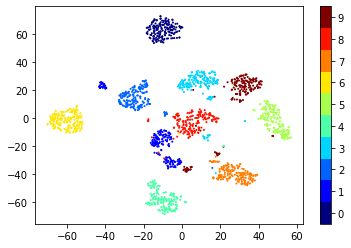

In [11]:
def get_data():
    digits = datasets.load_digits(n_class=10)
    return digits.data, digits.target


features, target = get_data()

tsne = TSNE(n_components=2)
data = pd.DataFrame(features)  # shape = (1797, 64)
tsne.fit_transform(data)
data = pd.DataFrame(tsne.embedding_, index=data.index)  # shape = (1797, 2)

plt.scatter(data[0], data[1], c=target, s=1, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-.5, 9.5)
plt.show()

In [ ]:
# tsne_data = pd.read_pickle('./tsne.pkl')
#
# y_data = dataset1.test_labels
# y_data = np.where(y_data == 1)[1] * (9.0 / 10)
# plt.scatter(tsne[0], tsne[1], c=y_data, s=1, cmap=plt.cm.get_cmap('jet', 10))
# plt.colorbar(ticks=range(10))
# plt.clim(-.5, 9.5)
# plt.show()